In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_dep as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.bert_conf
encoding_type = 'relative'
model_name = 'bert'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = generic.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.559951580152279 	 Validation loss: 0.39377086344411816 	 
  1%|          | 574/57400 [01:44<2:18:25,  6.84it/s]
Epoch 2 	 Training loss: 0.3786606606394572 	 Validation loss: 0.34843622577392447 	 
  2%|▏         | 1148/57400 [03:27<2:38:37,  5.91it/s]
Epoch 3 	 Training loss: 0.34342247278848176 	 Validation loss: 0.3333926599914745 	 
  3%|▎         | 1722/57400 [05:10<2:51:28,  5.41it/s]
Epoch 4 	 Training loss: 0.3231833521082011 	 Validation loss: 0.32249447299262224 	 
  4%|▍         | 2296/57400 [06:53<2:50:28,  5.39it/s]
Epoch 5 	 Training loss: 0.3076249026151484 	 Validation loss: 0.31571641539113 	 
  5%|▌         | 2870/57400 [08:36<2:31:41,  5.99it/s]
Epoch 6 	 Training loss: 0.2946060980030884 	 Validation loss: 0.3106558358265182 	 
  6%|▌         | 3444/57400 [10:19<2:21:23,  6.36it/s]
Epoch 7 	 Training loss: 0.2849776088827994 	 Validation loss: 0.30596046806392024 	 
  7%|▋         | 4018/57400 [12:03<2:38:04,  5.63it/s]
Epoch 8 	 Training 

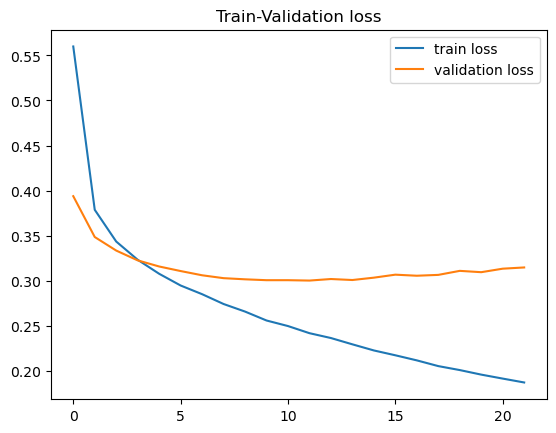

In [17]:

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.84, 'male': 0.875, 'average': 0.8574999999999999}
precision {'female': 0.875, 'male': 0.84, 'average': 0.8574999999999999}
f1 {'female': 0.8571428571428572, 'male': 0.8571428571428572, 'average': 0.8571428571428572}
accuracy 0.8571428571428571


Evaluación en el conjunto el conjunto to
recall {'female': 0.6482939632545932, 'male': 0.7177615571776156, 'average': 0.6830277602161043}
precision {'female': 0.6804407713498623, 'male': 0.6876456876456877, 'average': 0.684043229497775}
f1 {'female': 0.663978494623656, 'male': 0.7023809523809524, 'average': 0.6831797235023043}
accuracy 0.6843434343434344


Evaluación en el conjunto el conjunto as
recall {'female': 0.660377358490566, 'male': 0.7146464646464646, 'average': 0.6875119115685153}
precision {'female': 0.6843575418994413, 'male': 0.6919315403422983, 'average': 0.6881445411208698}
f1 {'female': 0.6721536351165981, 'male': 0.7031055900621118, 'average': 0.687629612589355}


In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about2'


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5864493974098345 	 Validation loss: 0.4044330322136313 	 
  1%|          | 574/57400 [01:41<2:41:49,  5.85it/s]
Epoch 2 	 Training loss: 0.38203219441171304 	 Validation loss: 0.3496685838800366 	 
  2%|▏         | 1148/57400 [03:22<2:30:36,  6.23it/s]
Epoch 3 	 Training loss: 0.3448776607677496 	 Validation loss: 0.3347152077545554 	 
  3%|▎         | 1722/57400 [05:04<2:33:39,  6.04it/s]
Epoch 4 	 Training loss: 0.32488747950941843 	 Validation loss: 0.3251308351755142 	 
  4%|▍         | 2296/57400 [06:46<2:33:15,  5.99it/s]
Epoch 5 	 Training loss: 0.30969791052025786 	 Validation loss: 0.31845497731435096 	 
  5%|▌         | 2870/57400 [08:27<2:39:33,  5.70it/s]
Epoch 6 	 Training loss: 0.29748846125831174 	 Validation loss: 0.311231908404221 	 
  6%|▌         | 3444/57400 [10:08<2:26:47,  6.13it/s]
Epoch 7 	 Training loss: 0.2855807586414058 	 Validation loss: 0.3077886359671415 	 
  7%|▋         | 4018/57400 [11:48<2:26:01,  6.09it/s]
Epoch 8 	 Trainin

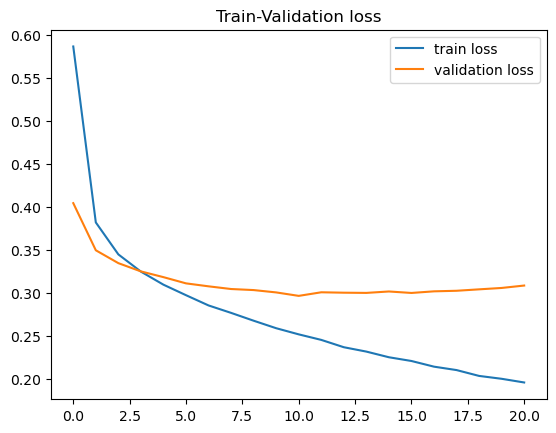

In [20]:

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [21]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8325, 'male': 0.859375, 'average': 0.8459375}
precision {'female': 0.8604651162790697, 'male': 0.8312342569269522, 'average': 0.845849686603011}
f1 {'female': 0.8462515883100381, 'male': 0.8450704225352113, 'average': 0.8456610054226247}
accuracy 0.8456632653061225


Evaluación en el conjunto el conjunto to
recall {'female': 0.6482939632545932, 'male': 0.7104622871046229, 'average': 0.679378125179608}
precision {'female': 0.674863387978142, 'male': 0.6854460093896714, 'average': 0.6801546986839067}
f1 {'female': 0.6613119143239625, 'male': 0.6977299880525686, 'average': 0.6795209511882656}
accuracy 0.6805555555555556


Evaluación en el conjunto el conjunto as
recall {'female': 0.6684636118598383, 'male': 0.7196969696969697, 'average': 0.694080290778404}
precision {'female': 0.6908077994428969, 'male': 0.6985294117647058, 'average': 0.6946686056038014}
f1 {'female': 0.6794520547945205, 'male': 0.708955223880597, 'average'

In [22]:
model =st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about3'


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5733176653081947 	 Validation loss: 0.4207873374728833 	 
  1%|          | 574/57400 [01:41<2:35:22,  6.10it/s]
Epoch 2 	 Training loss: 0.3854750525660631 	 Validation loss: 0.3511782197628991 	 
  2%|▏         | 1148/57400 [03:22<2:48:26,  5.57it/s]
Epoch 3 	 Training loss: 0.34431376217342 	 Validation loss: 0.3333207732540066 	 
  3%|▎         | 1722/57400 [05:04<2:34:33,  6.00it/s]
Epoch 4 	 Training loss: 0.3223617919282631 	 Validation loss: 0.3209454081321167 	 
  4%|▍         | 2296/57400 [06:45<2:24:48,  6.34it/s]
Epoch 5 	 Training loss: 0.3070870506275406 	 Validation loss: 0.3161825573040267 	 
  5%|▌         | 2870/57400 [08:26<2:26:55,  6.19it/s]
Epoch 6 	 Training loss: 0.29407023326964327 	 Validation loss: 0.3203074841176049 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:07<2:27:18,  6.10it/s]
Epoch 7 	 Training loss: 0.2827063960896136 	 Validation loss: 0.30715211948095744 	 
  7%|▋         | 4018/57400 [11:49<2:33:32,  5.

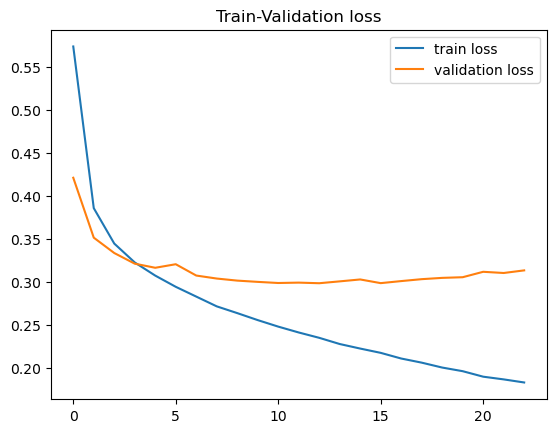

In [23]:

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [24]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.83, 'male': 0.859375, 'average': 0.8446875}
precision {'female': 0.8601036269430051, 'male': 0.8291457286432161, 'average': 0.8446246777931106}
f1 {'female': 0.8447837150127224, 'male': 0.843989769820972, 'average': 0.8443867424168472}
accuracy 0.8443877551020408


Evaluación en el conjunto el conjunto to
recall {'female': 0.6456692913385826, 'male': 0.6958637469586375, 'average': 0.6707665191486101}
precision {'female': 0.6630727762803235, 'male': 0.6793349168646081, 'average': 0.6712038465724658}
f1 {'female': 0.6542553191489361, 'male': 0.6875, 'average': 0.6708776595744681}
accuracy 0.6717171717171717


Evaluación en el conjunto el conjunto as
recall {'female': 0.6630727762803235, 'male': 0.7045454545454546, 'average': 0.683809115412889}
precision {'female': 0.6776859504132231, 'male': 0.6905940594059405, 'average': 0.6841400049095818}
f1 {'female': 0.6702997275204359, 'male': 0.6975, 'average': 0.6838998637602179}
a

Resultados finales

In [25]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8490635349941097
f1 etiqueta male: 0.8487343498330134
f1 etiqueta female:  0.849392720155206


TO
Resultado global f1: 0.6778594447550127
f1 etiqueta male: 0.6958703134778403
f1 etiqueta female:  0.6598485760321848


AS
Resultado global f1: 0.6885777052290439
f1 etiqueta male: 0.7031869379809029
f1 etiqueta female:  0.6739684724771848


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.849375
recall etiqueta male: 0.8645833333333334
recall etiqueta female:  0.8341666666666666


TO
Resultado global recall: 0.6777241348481075
recall etiqueta male: 0.708029197080292
recall etiqueta female:  0.647419072615923


AS
Resultado global recall: 0.6884671059199361
recall etiqueta male: 0.712962962962963
recall etiqueta female:  0.6639712488769093


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.8493247881320405
precision etiqueta male: 0.8334599951900561
precision etiqueta female:  0.865189581074025

# TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [24]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6965985683406272 	 Validation loss: 0.6932362580703477 	 
  1%|          | 574/57400 [01:43<2:23:44,  6.59it/s]
Epoch 2 	 Training loss: 0.6948183873596923 	 Validation loss: 0.6952103416798479 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:24<2:42:41,  5.76it/s]
Epoch 3 	 Training loss: 0.6949934509780764 	 Validation loss: 0.6981340707358668 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:04<2:37:07,  5.91it/s]
Epoch 4 	 Training loss: 0.6941310573330324 	 Validation loss: 0.6934239914861776 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [06:45<2:32:17,  6.03it/s]
Epoch 5 	 Training loss: 0.6932767019039248 	 Validation loss: 0.6954162898710219 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [08:26<2:33:15,  5.93it/s]
Epoch 6 	 Training loss: 0.6932259069087198 	 Validation loss: 0.69466619572397 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [10:07<2:18:19,  6.50it/s]
Epoch 7 	 Training

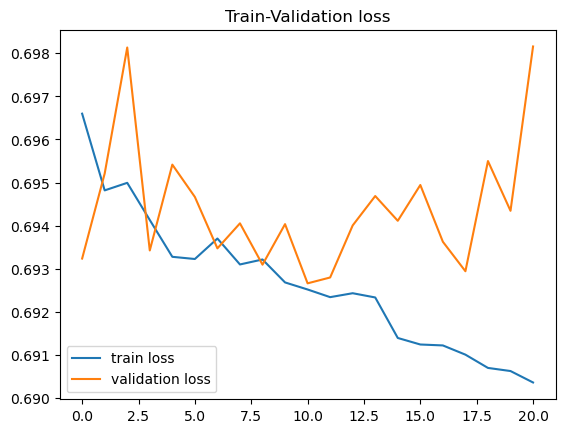

In [26]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [25]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.575, 'male': 0.4921875, 'average': 0.53359375}
precision {'female': 0.5411764705882353, 'male': 0.5264623955431755, 'average': 0.5338194330657053}
f1 {'female': 0.5575757575757575, 'male': 0.5087483176312247, 'average': 0.5331620376034911}
accuracy 0.5344387755102041


Evaluación en el conjunto el conjunto to
recall {'female': 0.48293963254593175, 'male': 0.5547445255474452, 'average': 0.5188420790466886}
precision {'female': 0.5013623978201635, 'male': 0.5364705882352941, 'average': 0.5189164930277288}
f1 {'female': 0.4919786096256684, 'male': 0.5454545454545455, 'average': 0.518716577540107}
accuracy 0.5202020202020202


Evaluación en el conjunto el conjunto as
recall {'female': 0.4528301886792453, 'male': 0.5782828282828283, 'average': 0.5155565084810367}
precision {'female': 0.5014925373134328, 'male': 0.5300925925925926, 'average': 0.5157925649530126}
f1 {'female': 0.4759206798866855, 'male': 0.5531400966183574, 'av

In [26]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to2'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6987439073128983 	 Validation loss: 0.6959784414808629 	 
  1%|          | 574/57400 [01:40<2:21:13,  6.71it/s]
Epoch 2 	 Training loss: 0.6980478146765705 	 Validation loss: 0.6931726528426349 	 
  2%|▏         | 1148/57400 [03:22<2:40:48,  5.83it/s]
Epoch 3 	 Training loss: 0.6968478731785086 	 Validation loss: 0.6951522897865813 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:03<2:24:09,  6.44it/s]
Epoch 4 	 Training loss: 0.6966236773683634 	 Validation loss: 0.6930722715490956 	 
  4%|▍         | 2296/57400 [06:44<2:29:10,  6.16it/s]
Epoch 5 	 Training loss: 0.6963145554273386 	 Validation loss: 0.6948907577385337 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:25<2:39:10,  5.71it/s]
Epoch 6 	 Training loss: 0.696417564610571 	 Validation loss: 0.6941340919268333 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:06<2:31:38,  5.93it/s]
Epoch 7 	 Training loss: 0.6960942347498306 	 Validation loss: 0.6925767801

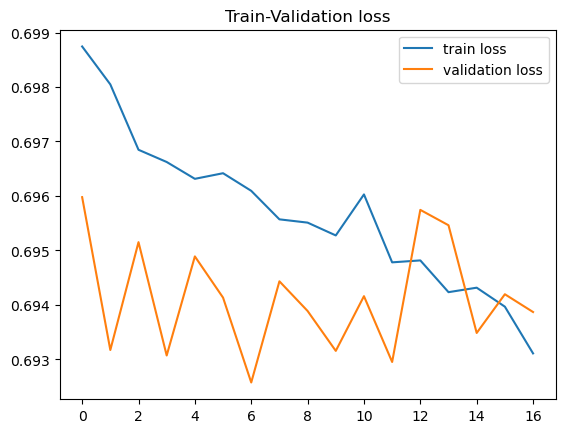

In [29]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [27]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.785, 'male': 0.2526041666666667, 'average': 0.5188020833333333}
precision {'female': 0.5224625623960066, 'male': 0.5300546448087432, 'average': 0.5262586036023749}
f1 {'female': 0.6273726273726273, 'male': 0.3421516754850089, 'average': 0.4847621514288181}
accuracy 0.5242346938775511


Evaluación en el conjunto el conjunto to
recall {'female': 0.7611548556430446, 'male': 0.30413625304136255, 'average': 0.5326455543422036}
precision {'female': 0.5034722222222222, 'male': 0.5787037037037037, 'average': 0.541087962962963}
f1 {'female': 0.6060606060606061, 'male': 0.3987240829346093, 'average': 0.5023923444976077}
accuracy 0.523989898989899


Evaluación en el conjunto el conjunto as
recall {'female': 0.8274932614555256, 'male': 0.18686868686868688, 'average': 0.5071809741621063}
precision {'female': 0.48807631160572335, 'male': 0.5362318840579711, 'average': 0.5121540978318472}
f1 {'female': 0.614, 'male': 0.2771535580524344

In [28]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to3'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6979253604644682 	 Validation loss: 0.6947003188779799 	 
  1%|          | 574/57400 [01:41<2:38:38,  5.97it/s]
Epoch 2 	 Training loss: 0.6964955791986778 	 Validation loss: 0.6935346348811005 	 
  2%|▏         | 1148/57400 [03:22<2:13:07,  7.04it/s]
Epoch 3 	 Training loss: 0.6962574028802666 	 Validation loss: 0.6922047229136451 	 
  3%|▎         | 1722/57400 [05:03<2:33:03,  6.06it/s]
Epoch 4 	 Training loss: 0.6959578732372577 	 Validation loss: 0.6954062530549906 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:44<2:23:18,  6.41it/s]
Epoch 5 	 Training loss: 0.6953190240087409 	 Validation loss: 0.6933362938589969 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:26<2:30:12,  6.05it/s]
Epoch 6 	 Training loss: 0.6950711682698453 	 Validation loss: 0.6942770430597208 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [10:07<2:38:02,  5.69it/s]
Epoch 7 	 Training loss: 0.6953528832890846 	 Validation loss: 0.692733157

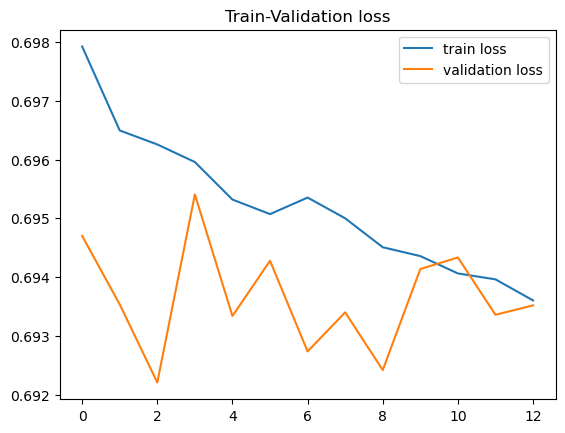

In [32]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [29]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.1025, 'male': 0.8333333333333334, 'average': 0.4679166666666667}
precision {'female': 0.3904761904761905, 'male': 0.47128129602356406, 'average': 0.4308787432498773}
f1 {'female': 0.16237623762376238, 'male': 0.6020696142991533, 'average': 0.38222292596145785}
accuracy 0.4604591836734694


Evaluación en el conjunto el conjunto to
recall {'female': 0.13910761154855644, 'male': 0.8637469586374696, 'average': 0.501427285093013}
precision {'female': 0.48623853211009177, 'male': 0.5197657393850659, 'average': 0.5030021357475788}
f1 {'female': 0.21632653061224488, 'male': 0.6489945155393054, 'average': 0.4326605230757752}
accuracy 0.5151515151515151


Evaluación en el conjunto el conjunto as
recall {'female': 0.11590296495956873, 'male': 0.8308080808080808, 'average': 0.47335552288382476}
precision {'female': 0.39090909090909093, 'male': 0.5007610350076104, 'average': 0.4458350629583506}
f1 {'female': 0.1787941787941788, 'male

Resultados finales

In [30]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.46671570499792236
f1 etiqueta male: 0.48432320247179567
f1 etiqueta female:  0.44910820752404906


TO
Resultado global f1: 0.48458981503783
f1 etiqueta male: 0.5310577146428201
f1 etiqueta female:  0.4381219154328398


AS
Resultado global f1: 0.4539816341499357
f1 etiqueta male: 0.48505831540625
f1 etiqueta female:  0.42290495289362146


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5067708333333334
recall etiqueta male: 0.5260416666666667
recall etiqueta female:  0.4875


TO
Resultado global recall: 0.5176383061606351
recall etiqueta male: 0.5742092457420924
recall etiqueta female:  0.46106736657917763


AS
Resultado global recall: 0.4986976685089893
recall etiqueta male: 0.531986531986532
recall etiqueta female:  0.46540880503144655


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.49698559330598585
precision etiqueta male: 0.5092661121251609
precision etiqueta female:  0.48470507448

# AS

In [35]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [36]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as1'


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6971371589222021 	 Validation loss: 0.6945519709991197 	 
  1%|          | 574/57400 [01:41<2:40:30,  5.90it/s]
Epoch 2 	 Training loss: 0.6956945715880976 	 Validation loss: 0.6920247613373449 	 
  2%|▏         | 1148/57400 [03:23<2:30:40,  6.22it/s]
Epoch 3 	 Training loss: 0.6950428411104953 	 Validation loss: 0.6911853743811786 	 
  3%|▎         | 1722/57400 [05:05<2:35:19,  5.97it/s]
Epoch 4 	 Training loss: 0.6932858166378965 	 Validation loss: 0.6916616619643519 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:47<2:41:11,  5.70it/s]
Epoch 5 	 Training loss: 0.6918410595493449 	 Validation loss: 0.6908425506898912 	 
  5%|▌         | 2870/57400 [08:29<2:31:52,  5.98it/s]
Epoch 6 	 Training loss: 0.6899951996495914 	 Validation loss: 0.6934010265237194 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:10<2:28:52,  6.04it/s]
Epoch 7 	 Training loss: 0.6874875790773783 	 Validation loss: 0.6899424498364076 	 
  7%|▋         | 4

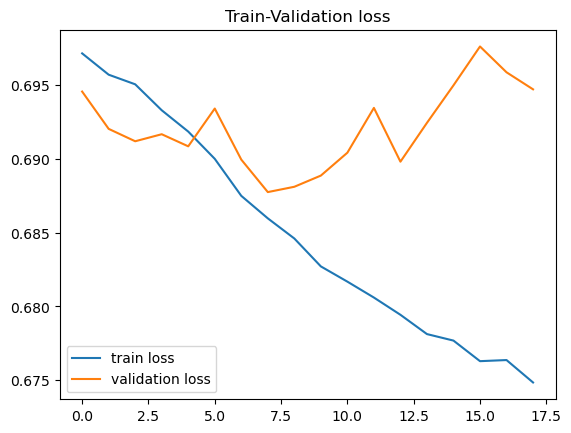

In [37]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [38]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.81, 'male': 0.6197916666666666, 'average': 0.7148958333333333}
precision {'female': 0.6893617021276596, 'male': 0.7579617834394905, 'average': 0.723661742783575}
f1 {'female': 0.7448275862068966, 'male': 0.681948424068768, 'average': 0.7133880051378323}
accuracy 0.7168367346938775


Evaluación en el conjunto el conjunto to
recall {'female': 0.7296587926509186, 'male': 0.6642335766423357, 'average': 0.6969461846466272}
precision {'female': 0.6682692307692307, 'male': 0.726063829787234, 'average': 0.6971665302782324}
f1 {'female': 0.6976160602258469, 'male': 0.6937738246505717, 'average': 0.6956949424382093}
accuracy 0.6957070707070707


Evaluación en el conjunto el conjunto as
recall {'female': 0.8544474393530997, 'male': 0.6893939393939394, 'average': 0.7719206893735195}
precision {'female': 0.7204545454545455, 'male': 0.8348623853211009, 'average': 0.7776584653878231}
f1 {'female': 0.7817509247842169, 'male': 0.75518672

In [39]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as2'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6996885627404322 	 Validation loss: 0.6925464030039512 	 
  1%|          | 574/57400 [01:41<2:33:26,  6.17it/s]
Epoch 2 	 Training loss: 0.6969631211475212 	 Validation loss: 0.6911592170343561 	 
  2%|▏         | 1148/57400 [03:23<2:27:53,  6.34it/s]
Epoch 3 	 Training loss: 0.6951811873331303 	 Validation loss: 0.6927114866547666 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:04<2:29:34,  6.20it/s]
Epoch 4 	 Training loss: 0.6928107229674735 	 Validation loss: 0.6908152952032575 	 
  4%|▍         | 2296/57400 [06:46<2:34:37,  5.94it/s]
Epoch 5 	 Training loss: 0.6917526554770586 	 Validation loss: 0.6917836777234482 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:28<2:10:38,  6.96it/s]
Epoch 6 	 Training loss: 0.6899898502884841 	 Validation loss: 0.6920434590113365 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:09<2:33:18,  5.87it/s]
Epoch 7 	 Training loss: 0.6894940101518864 	 Validation loss: 0.691394894

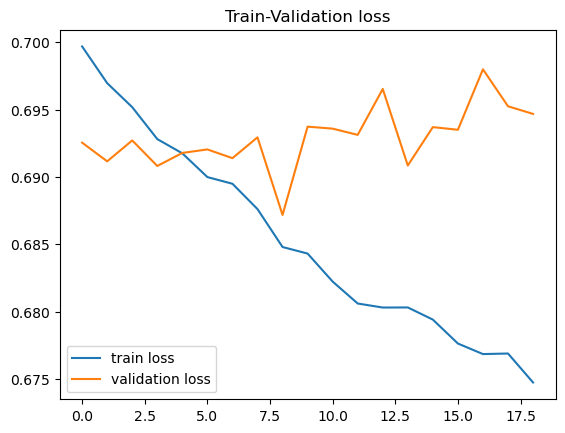

In [40]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [41]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8025, 'male': 0.6067708333333334, 'average': 0.7046354166666666}
precision {'female': 0.6800847457627118, 'male': 0.7467948717948718, 'average': 0.7134398087787919}
f1 {'female': 0.7362385321100917, 'male': 0.6695402298850575, 'average': 0.7028893809975746}
accuracy 0.7066326530612245


Evaluación en el conjunto el conjunto to
recall {'female': 0.7559055118110236, 'male': 0.6155717761557178, 'average': 0.6857386439833707}
precision {'female': 0.6457399103139013, 'male': 0.7312138728323699, 'average': 0.6884768915731356}
f1 {'female': 0.6964933494558645, 'male': 0.6684280052840158, 'average': 0.6824606773699402}
accuracy 0.6830808080808081


Evaluación en el conjunto el conjunto as
recall {'female': 0.862533692722372, 'male': 0.6818181818181818, 'average': 0.7721759372702769}
precision {'female': 0.7174887892376681, 'male': 0.8411214953271028, 'average': 0.7793051422823855}
f1 {'female': 0.7833537331701346, 'male': 0.7531

In [42]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as3'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6988816541661784 	 Validation loss: 0.6937732413663702 	 
  1%|          | 574/57400 [01:46<3:08:41,  5.02it/s]
Epoch 2 	 Training loss: 0.6996531109568964 	 Validation loss: 0.6941585560976449 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:33<2:30:06,  6.25it/s]
Epoch 3 	 Training loss: 0.6996973999078265 	 Validation loss: 0.6941964323237791 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:20<2:48:02,  5.52it/s]
Epoch 4 	 Training loss: 0.6991955704389964 	 Validation loss: 0.6935205651541888 	 
  4%|▍         | 2296/57400 [07:06<2:24:37,  6.35it/s]
Epoch 5 	 Training loss: 0.6991885865191549 	 Validation loss: 0.6925544324567763 	 
  5%|▌         | 2870/57400 [08:53<2:42:46,  5.58it/s]
Epoch 6 	 Training loss: 0.6999423998158153 	 Validation loss: 0.693858378014322 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:40<2:35:15,  5.79it/s]
Epoch 7 	 Training loss: 0.6987248849162657 	 Validation loss: 0.6940216967

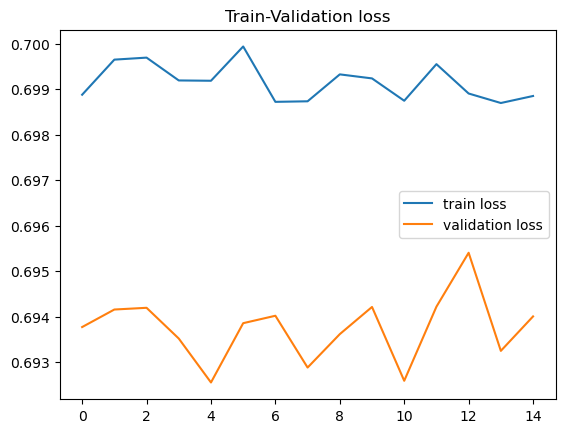

In [43]:
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [44]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.9075, 'male': 0.171875, 'average': 0.5396875}
precision {'female': 0.5330396475770925, 'male': 0.6407766990291263, 'average': 0.5869081733031094}
f1 {'female': 0.6716003700277521, 'male': 0.27104722792607805, 'average': 0.47132379897691506}
accuracy 0.5471938775510204


Evaluación en el conjunto el conjunto to
recall {'female': 0.8976377952755905, 'male': 0.1070559610705596, 'average': 0.5023468781730751}
precision {'female': 0.4823695345557123, 'male': 0.5301204819277109, 'average': 0.5062450082417116}
f1 {'female': 0.6275229357798167, 'male': 0.17813765182186234, 'average': 0.4028302938008395}
accuracy 0.48737373737373735


Evaluación en el conjunto el conjunto as
recall {'female': 0.8490566037735849, 'male': 0.16414141414141414, 'average': 0.5065990089574995}
precision {'female': 0.48761609907120745, 'male': 0.5371900826446281, 'average': 0.5124030908579178}
f1 {'female': 0.6194690265486726, 'male': 0.2514506769825919

Resultados finales

In [45]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.6292003950374406
f1 etiqueta male: 0.5408452939599678
f1 etiqueta female:  0.7175554961149134


TO
Resultado global f1: 0.5936619712029964
f1 etiqueta male: 0.5134464939188166
f1 etiqueta female:  0.673877448487176


AS
Resultado global f1: 0.6573915264651875
f1 etiqueta male: 0.5865918247627002
f1 etiqueta female:  0.7281912281676747


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.6292003950374406
recall etiqueta male: 0.5408452939599678
recall etiqueta female:  0.7175554961149134


TO
Resultado global recall: 0.5936619712029964
recall etiqueta male: 0.5134464939188166
recall etiqueta female:  0.673877448487176


AS
Resultado global recall: 0.6573915264651875
recall etiqueta male: 0.5865918247627002
recall etiqueta female:  0.7281912281676747


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.6292003950374406
precision etiqueta male: 0.5408452939599678
precision etiqueta female:  0.717